# Tutorial notebook

This notebook runs the full training pipeline, including:
* training the irreducible loss model on the holdout set
* training the target model

The dataset is CIFAR-10, both target model and irreducible loss model have a Resnet-18 architecture.

Note: Before you can run this, you need to install the dependencies and activate the environment (see readme).

In [ ]:
! git clone https://github.com/OATML/RHO-Loss.git

fatal: destination path 'RHO-Loss' already exists and is not an empty directory.


In [ ]:
%cd RHO-Loss/

/content/RHO-Loss


In [ ]:
!pip install pytorch-lightning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 62.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
import torch
import torch.nn as nn

class BNL(nn.Module):
    """
        Bayesian Normalization Layer (BNL).

    This layer replaces traditional normalization layers like BatchNorm,
    LayerNorm, and InstanceNorm. It adapts normalization to account for Bayesian
    inference, making the model more robust to variations and uncertainties in
    the data.

    BNL adds gaussian noise during both inference and trainig stages.

    This implementation includes parameters named `weight` and `bias` to directly
    match those used in PyTorch's BatchNorm, LayerNorm, and InstanceNorm layers
    for compatibility when loading state dictionaries.

    Args:
        num_features (int, list, tuple): Number of features in the input, matches channels
                                         in conv layers or features in linear layers. Can
                                         be a single integer or a list/tuple for complex scenarios.
    """
    def __init__(self, num_features):
        super(BNL, self).__init__()
        # Check if num_features is a list or tuple, convert if necessary
        if isinstance(num_features, int):
            num_features = (num_features,)

        self.num_features = num_features
        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))
        self.eps = 1e-5

    def forward(self, x):
        if len(self.num_features) == 1:  # Traditional usage like BatchNorm
            mean = x.mean([0, 2, 3], keepdim=True) if x.dim() == 4 else x.mean(0, keepdim=True)
            var = x.var([0, 2, 3], keepdim=True) if x.dim() == 4 else x.var(0, keepdim=True)
            x_normalized = (x - mean) / torch.sqrt(var + self.eps)

            noise = torch.randn(self.weight.shape, device=x.device)
            gamma_noisy = self.weight * (1 + noise)

            if x.dim() == 4:
                gamma_noisy = gamma_noisy.view(1, -1, 1, 1)
                bias = self.bias.view(1, -1, 1, 1)
            elif x.dim() == 2:
                gamma_noisy = gamma_noisy.view(1, -1)
                bias = self.bias.view(1, -1)

            return gamma_noisy * x_normalized + bias
        else:  # LayerNorm-like usage
            mean = x.mean(dim=tuple(range(x.dim())[1:]), keepdim=True)
            var = x.var(dim=tuple(range(x.dim())[1:]), keepdim=True, unbiased=False)
            x_normalized = (x - mean) / torch.sqrt(var + self.eps)

            noise = torch.randn(self.weight.shape, device=x.device)
            gamma_noisy = self.weight * (1 + noise)

            weight = self.weight.view((1,) + self.num_features + (1,) * (x.dim() - len(self.num_features) - 1))
            bias = self.bias.view((1,) + self.num_features + (1,) * (x.dim() - len(self.num_features) - 1))

            return gamma_noisy * x_normalized + bias

In [ ]:
class BNLBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BNLBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = BNL(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = BNL(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                BNL(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class BNLResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(BNLResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = BNL(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def BNLResNet18():
    return BNLResNet(BNLBasicBlock, [2, 2, 2, 2])

RHO+ABNN

In [ ]:
import torch
# Load the checkpoint
ckpt = torch.load("epoch_113.ckpt", map_location="cpu",weights_only=False)

# Extract and fix the state_dict
state_dict = ckpt["state_dict"]
new_state_dict = {}

# Strip "large_model." from the keys
for key in state_dict:
    new_key = key.replace("large_model.", "")
    new_state_dict[new_key] = state_dict[key]

# Load into your model
filtered_state_dict = {k: v for k, v in new_state_dict.items() if 'running_mean' not in k and 'running_var' not in k and 'num_batches_tracked' not in k}
model = BNLResNet18()
model.load_state_dict(filtered_state_dict)

<All keys matched successfully>

NLL without ABNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import numpy as np
from torchsummary import summary
from torch.nn.functional import softmax
import torch.nn.functional as F

In [ ]:
from torchvision import transforms

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)



In [ ]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda:0


In [ ]:
model.eval()
all_probs = []
true_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)  # logits
        probs = torch.softmax(outputs, dim=1)  # convert logits to probabilities

        all_probs.append(probs)
        true_labels.append(labels)

# Concatenate everything
all_probs = torch.cat(all_probs, dim=0)            # Shape: [N, C]
true_labels = torch.cat(true_labels, dim=0)        # Shape: [N]

In [ ]:
import torch.nn.functional as F

# Use log probabilities for NLL
log_probs = torch.log(all_probs + 1e-12)  # for numerical stability

# Compute Negative Log-Likelihood
nll = F.nll_loss(log_probs, true_labels)
print(f"NLL (Single Model): {nll:.4f}")

NLL (Single Model): 1.7828


In [ ]:
class ABNNLoss(torch.nn.Module):
    def __init__(self, Num_classes, model_parameters, Weight_decay=1e-4):
        super(ABNNLoss, self).__init__()
        self.model_parameters = model_parameters
        self.Weight_decay = Weight_decay
        self.eta = nn.Parameter(torch.ones(Num_classes))

    def forward(self, outputs, labels):
        # Calculate the three loss components
        nll_loss = self.negative_log_likelihood(outputs, labels)
        log_prior_loss = self.negative_log_prior(self.model_parameters, self.Weight_decay)
        custom_ce_loss = self.custom_cross_entropy_loss(outputs, labels, self.eta)

        # Sum up all three components to form the ABNN loss
        total_loss = nll_loss + log_prior_loss + custom_ce_loss
        return total_loss

    @staticmethod
    def negative_log_likelihood(outputs, labels):
        # Negative Log Likelihood (NLL) or MLE Loss:
        # NLL = -∑ log P(y_i | x_i, ω)
        return torch.nn.functional.cross_entropy(outputs, labels)

    def negative_log_prior(self, model_parameters, Weight_decay=1e-4):
        # Negative Log Prior with Gaussian Prior (L2 Regularization):
        # log P(ω) = λ ∑ ω^2 where λ (weight decay) = (1/2σ^2)
        l2_reg = sum(p.pow(2).sum() for p in model_parameters)
        return Weight_decay * l2_reg

    def custom_cross_entropy_loss(self, outputs, labels, eta):
        # Custom Cross-Entropy Loss:
        # E(ω) = -∑ η_i log P(y_i | x_i, ω)
        log_probs = torch.nn.functional.log_softmax(outputs, dim=1)
        weighted_log_probs = eta[labels] * log_probs.gather(1, labels.unsqueeze(1)).squeeze(1)
        return -torch.mean(weighted_log_probs)

In [ ]:
loss_func = ABNNLoss(10, model.parameters()).to(device)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0057, momentum=0.9, weight_decay=5e-4)


NameError: name 'model' is not defined

In [ ]:
! pip install netcal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 124.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import netcal.metrics as metrics
from netcal.metrics import ECE
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve

ModuleNotFoundError: No module named 'numpy.rec'

In [ ]:
%rm -rf data

In [ ]:
!pip install --upgrade --force-reinstall numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 115.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matplotlib 3.7.5 requires numpy<2,>=1.20, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.


In [ ]:

print('Start Training')

# Timing the training process
start_time = time.time()

# List to store loss values
train_losses = []
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        eta = torch.rand(labels.size(0), device=device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_losses.append(loss.item())
    print(f'[Epoch {epoch + 1}, Loss: {running_loss}')
    running_loss = 0.0

end_time = time.time()

print('Finished Training')
print(f'Time taken to train the model: {end_time - start_time:.2f} seconds')

Start Training
[Epoch 1, Loss: 862.4734661579132
[Epoch 2, Loss: 657.6451494693756
[Epoch 3, Loss: 619.3060858249664
[Epoch 4, Loss: 579.5586772561073
[Epoch 5, Loss: 568.1233695745468
[Epoch 6, Loss: 540.1672561168671
[Epoch 7, Loss: 525.1075974702835
[Epoch 8, Loss: 503.56338477134705
[Epoch 9, Loss: 498.4417510032654
[Epoch 10, Loss: 496.62491196393967
[Epoch 11, Loss: 483.50263118743896
[Epoch 12, Loss: 473.1645570397377
[Epoch 13, Loss: 469.17793464660645
[Epoch 14, Loss: 456.07257401943207
[Epoch 15, Loss: 451.30593103170395
[Epoch 16, Loss: 451.98159915208817
[Epoch 17, Loss: 443.9652162194252
[Epoch 18, Loss: 438.64993929862976
[Epoch 19, Loss: 433.2899259328842
[Epoch 20, Loss: 431.78097385168076
Finished Training
Time taken to train the model: 1226.16 seconds


In [ ]:
! git clone https://github.com/OATML/RHO-Loss.git

In [ ]:
%cd RHO-Loss/

/content/RHO-Loss


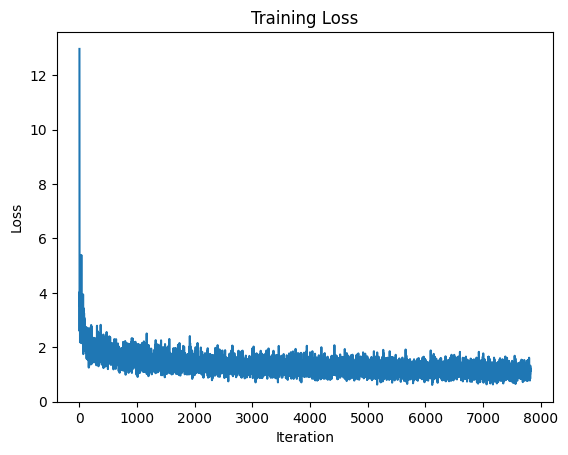

In [ ]:
# Plotting the training loss
plt.figure()
plt.plot(train_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
# Make sure the model is in evaluation mode
model.eval()

# Variables to track the correct predictions and total predictions
correct = 0
total = 0

# Ensure no gradients are calculated as we are only making predictions
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # Collect predictions from multiple evaluations
        predictions = []
        for _ in range(50):
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            predictions.append(preds)

        # Calculate the mode of the predictions
        predictions = torch.stack(predictions)
        predicted, _ = torch.mode(predictions, dim=0)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

Accuracy of the network on the test images: 87.08%


In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': running_loss,
}, 'rhoabnn.ckpt')


Evaluationg Resnet with rho loss

In [ ]:
# Load the checkpoint
ckpt = torch.load("epoch_113.ckpt", map_location="cpu",weights_only=False)

# Extract and fix the state_dict
state_dict = ckpt["state_dict"]
new_state_dict = {}

# Strip "large_model." from the keys
for key in state_dict:
    new_key = key.replace("large_model.", "")
    new_state_dict[new_key] = state_dict[key]

# Load into your model
#filtered_state_dict = {k: v for k, v in new_state_dict.items() if 'running_mean' not in k and 'running_var' not in k and 'num_batches_tracked' not in k}
model1 = ResNet18()

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model1.to(device)
model1.load_state_dict(new_state_dict)

# Set to eval mode (optional)
model1.eval()

Using device: cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
"""ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


def resnet18_imagenet(pretrained=False, classes=10):
    model = torchvision.models.resnet18(pretrained=pretrained, num_classes=1000)
    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    )
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(512, classes, bias=True)
    return model

def resnet50_imagenet(pretrained=False, classes=10):
    model = torchvision.models.resnet50(pretrained=pretrained, num_classes=1000)
    model.fc = nn.Linear(512, classes, bias=True)
    return model

In [ ]:
# Make sure the model is in evaluation mode
model1.eval()

# Variables to track the correct predictions and total predictions
correct = 0
total = 0

# Ensure no gradients are calculated as we are only making predictions
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # Collect predictions from multiple evaluations
        predictions = []
        for _ in range(50):
            outputs = model1(images)
            _, preds = torch.max(outputs.data, 1)
            predictions.append(preds)

        # Calculate the mode of the predictions
        predictions = torch.stack(predictions)
        predicted, _ = torch.mode(predictions, dim=0)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

Accuracy of the network on the test images: 89.23%


Training ABNN for resnet without rho loss


In [ ]:
import torch
# Load the checkpoint
ckpt = torch.load("epoch_142.ckpt", map_location="cpu",weights_only=False)

# Extract and fix the state_dict
state_dict = ckpt["state_dict"]
new_state_dict = {}

# Strip "large_model." from the keys
for key in state_dict:
    new_key = key.replace("large_model.", "")
    new_state_dict[new_key] = state_dict[key]

# Load into your model
filtered_state_dict = {k: v for k, v in new_state_dict.items() if 'running_mean' not in k and 'running_var' not in k and 'num_batches_tracked' not in k}
model2 = BNLResNet18()
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model2.to(device)
model2.load_state_dict(filtered_state_dict)

# Set to eval mode (optional)
model2.eval()

Using device: cuda:0


BNLResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BNL()
  (layer1): Sequential(
    (0): BNLBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BNL()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BNL()
      (shortcut): Sequential()
    )
    (1): BNLBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BNL()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BNL()
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BNLBasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BNL()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BNL()
      (shortc

In [ ]:
loss_func = ABNNLoss(10, model.parameters()).to(device)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0057, momentum=0.9, weight_decay=5e-4)


In [ ]:

print('Start Training')

# Timing the training process
start_time = time.time()

# List to store loss values
train_losses = []
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        eta = torch.rand(labels.size(0), device=device)

        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_losses.append(loss.item())
    print(f'[Epoch {epoch + 1}, Loss: {running_loss}')
    running_loss = 0.0

end_time = time.time()

print('Finished Training')
print(f'Time taken to train the model: {end_time - start_time:.2f} seconds')

Start Training
[Epoch 1, Loss: 808.6131503582001
[Epoch 2, Loss: 626.1823525428772
[Epoch 3, Loss: 591.6339709758759
[Epoch 4, Loss: 566.3530452847481
[Epoch 5, Loss: 549.651691198349
[Epoch 6, Loss: 533.3991477489471
[Epoch 7, Loss: 522.094912648201
[Epoch 8, Loss: 522.9564603567123
[Epoch 9, Loss: 506.3806129693985
[Epoch 10, Loss: 509.3108307123184
[Epoch 11, Loss: 496.49385553598404
[Epoch 12, Loss: 492.7394669055939
[Epoch 13, Loss: 485.9119859933853
[Epoch 14, Loss: 480.14716923236847
[Epoch 15, Loss: 475.07631528377533
[Epoch 16, Loss: 471.64194172620773
[Epoch 17, Loss: 464.5568643808365
[Epoch 18, Loss: 463.2601583600044
[Epoch 19, Loss: 459.07375156879425
[Epoch 20, Loss: 456.3744861483574
Finished Training
Time taken to train the model: 1199.59 seconds


In [ ]:
# Make sure the model is in evaluation mode
model2.eval()

# Variables to track the correct predictions and total predictions
correct = 0
total = 0

# Ensure no gradients are calculated as we are only making predictions
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # Collect predictions from multiple evaluations
        predictions = []
        for _ in range(50):
            outputs = model2(images)
            _, preds = torch.max(outputs.data, 1)
            predictions.append(preds)

        # Calculate the mode of the predictions
        predictions = torch.stack(predictions)
        predicted, _ = torch.mode(predictions, dim=0)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

Accuracy of the network on the test images: 85.57%


In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model2.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': running_loss,
}, 'resnetabnn.ckpt')

Evaluaing restnet without rho loss

In [ ]:
!pip uninstall -y numpy matplotlib torch torchvision pytorch-lightning torchmetrics plotnine
!pip install numpy==1.24.4 matplotlib==3.8.2 torch torchvision pytorch-lightning==2.1.3 torchmetrics plotnine



Found existing installation: numpy 2.2.5
Uninstalling numpy-2.2.5:
  Successfully uninstalled numpy-2.2.5
Found existing installation: matplotlib 3.7.5
Uninstalling matplotlib-3.7.5:
  Successfully uninstalled matplotlib-3.7.5
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: pytorch-lightning 2.5.1.post0
Uninstalling pytorch-lightning-2.5.1.post0:
  Successfully uninstalled pytorch-lightning-2.5.1.post0
Found existing installation: torchmetrics 1.7.1
Uninstalling torchmetrics-1.7.1:
  Successfully uninstalled torchmetrics-1.7.1
Found existing installation: plotnine 0.14.5
Uninstalling plotnine-0.14.5:
  Successfully uninstalled plotnine-0.14.5
  Using cached torchmetrics-1.7.1-py3-none-any.whl.metadata (21 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%cd RHO-Loss

/content/RHO-Loss


In [ ]:
from pytorch_lightning import LightningModule
# Load the checkpoint
ckpt = torch.load("epoch_142.ckpt", map_location="cpu",weights_only=False)

# Extract and fix the state_dict
state_dict = ckpt["state_dict"]
new_state_dict = {}

# Strip "large_model." from the keys
for key in state_dict:
    new_key = key.replace("large_model.", "")
    new_state_dict[new_key] = state_dict[key]

# Load into your model
#filtered_state_dict = {k: v for k, v in new_state_dict.items() if 'running_mean' not in k and 'running_var' not in k and 'num_batches_tracked' not in k}
model4 = ResNet18()

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model4.to(device)
model4.load_state_dict(new_state_dict)

# Set to eval mode (optional)
model4.eval()

Using device: cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
# Make sure the model is in evaluation mode
model4.eval()

# Variables to track the correct predictions and total predictions
correct = 0
total = 0

# Ensure no gradients are calculated as we are only making predictions
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # Collect predictions from multiple evaluations
        predictions = []
        for _ in range(50):
            outputs = model4(images)
            _, preds = torch.max(outputs.data, 1)
            predictions.append(preds)

        # Calculate the mode of the predictions
        predictions = torch.stack(predictions)
        predicted, _ = torch.mode(predictions, dim=0)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

Accuracy of the network on the test images: 85.67%


Multiple ABNN instances

In [ ]:
import torch
import time
import random
import numpy as np

# Define a function to set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# Train one instance of the model
def train_one_instance(model_id, trainloader, device, loss_func, num_epochs=20):
    print(f"Training model {model_id}")

    set_seed(42 + model_id)  # Different seed for each instance

    model = BNLResNet18().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()

    start_time = time.time()
    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            eta = torch.rand(labels.size(0), device=device)  # Unused here?

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_losses.append(loss.item())

        print(f'[Model {model_id}, Epoch {epoch + 1}] Loss: {running_loss:.4f}')

    end_time = time.time()
    print(f'Model {model_id} Finished Training in {end_time - start_time:.2f} seconds')

    # Save the model
    torch.save(model.state_dict(), f"bnlresnet18_instance_{model_id}.pth")

    return model

In [ ]:
def ensemble_predict(models, dataloader, device):
    all_outputs = []

    for model in models:
        model.eval()
        outputs = []
        with torch.no_grad():
            for data in dataloader:
                inputs, _ = data
                inputs = inputs.to(device)
                output = torch.softmax(model(inputs), dim=1)  # probability outputs
                outputs.append(output.cpu())
        all_outputs.append(torch.cat(outputs))

    # Average predictions
    ensemble_output = torch.mean(torch.stack(all_outputs), dim=0)
    return ensemble_output

In [ ]:
loss_func = ABNNLoss(10, model.parameters()).to(device)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0057, momentum=0.9, weight_decay=5e-4)


In [ ]:
# Train 4 instances
models = []
for i in range(4):
    model = train_one_instance(i, trainloader, device, loss_func)
    models.append(model)

# Perform ensemble inference
ensemble_probs = ensemble_predict(models, testloader, device)

# If you want hard labels:
ensemble_preds = torch.argmax(ensemble_probs, dim=1)

Training model 0
[Model 0, Epoch 1] Loss: 1481.0283
[Model 0, Epoch 2] Loss: 1217.8668
[Model 0, Epoch 3] Loss: 1094.2764
[Model 0, Epoch 4] Loss: 980.1893
[Model 0, Epoch 5] Loss: 872.5084
[Model 0, Epoch 6] Loss: 794.0697
[Model 0, Epoch 7] Loss: 735.5834
[Model 0, Epoch 8] Loss: 687.5649
[Model 0, Epoch 9] Loss: 639.6671
[Model 0, Epoch 10] Loss: 600.2663
[Model 0, Epoch 11] Loss: 579.2804
[Model 0, Epoch 12] Loss: 553.8263
[Model 0, Epoch 13] Loss: 526.9241
[Model 0, Epoch 14] Loss: 505.1476
[Model 0, Epoch 15] Loss: 495.4999
[Model 0, Epoch 16] Loss: 476.8181
[Model 0, Epoch 17] Loss: 465.6735
[Model 0, Epoch 18] Loss: 446.4739
[Model 0, Epoch 19] Loss: 434.7401
[Model 0, Epoch 20] Loss: 428.5114
Model 0 Finished Training in 1272.23 seconds
Training model 1
[Model 1, Epoch 1] Loss: 1462.9839
[Model 1, Epoch 2] Loss: 1217.3644
[Model 1, Epoch 3] Loss: 1088.3284
[Model 1, Epoch 4] Loss: 966.7893
[Model 1, Epoch 5] Loss: 866.1179
[Model 1, Epoch 6] Loss: 788.1896
[Model 1, Epoch 7] L

In [ ]:
import torch.nn.functional as F

def compute_NLL(probs, labels):
    """
    probs: tensor of shape (N, C) - ensemble probabilities (after softmax and averaging)
    labels: tensor of shape (N,) - ground truth labels
    """
    # Use log probabilities and gather only for correct classes
    log_probs = torch.log(probs + 1e-12)  # avoid log(0)
    nll = F.nll_loss(log_probs, labels, reduction='mean')
    return nll.item()

In [ ]:
# Get true labels from testloader
true_labels = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        true_labels.extend(labels)

# Convert to a torch tensor
true_labels = torch.tensor(true_labels, dtype=torch.long, device=ensemble_probs.device)

NameError: name 'ensemble_probs' is not defined

In [ ]:
# Assuming `ensemble_probs` is of shape [N, C] and already averaged over ensemble members
# And `true_labels` is a 1D tensor of length N

nll = compute_NLL(ensemble_probs, true_labels)
print(f"NLL (Ensemble): {nll:.4f}")

NLL (Ensemble): 0.5193


In [ ]:
"""ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


def resnet18_imagenet(pretrained=False, classes=10):
    model = torchvision.models.resnet18(pretrained=pretrained, num_classes=1000)
    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    )
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(512, classes, bias=True)
    return model

def resnet50_imagenet(pretrained=False, classes=10):
    model = torchvision.models.resnet50(pretrained=pretrained, num_classes=1000)
    model.fc = nn.Linear(512, classes, bias=True)
    return model

In [ ]:
class BNLBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BNLBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = BNL(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = BNL(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                BNL(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class BNLResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(BNLResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = BNL(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def BNLResNet18():
    return BNLResNet(BNLBasicBlock, [2, 2, 2, 2])

RESNET 18 CIFAR 100 WITHOUT RHO LOSS ABNN


In [ ]:
import torch
# Load the checkpoint
ckpt = torch.load("epoch_167.ckpt", map_location="cpu",weights_only=False)

# Extract and fix the state_dict
state_dict = ckpt["state_dict"]
new_state_dict = {}

# Strip "large_model." from the keys
for key in state_dict:
    new_key = key.replace("large_model.", "")
    new_state_dict[new_key] = state_dict[key]

# Load into your model
filtered_state_dict = {k: v for k, v in new_state_dict.items() if 'running_mean' not in k and 'running_var' not in k and 'num_batches_tracked' not in k}
model5 = BNLResNet18()
model5.load_state_dict(filtered_state_dict)

<All keys matched successfully>

In [ ]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model5.to(device)

Using device: cuda:0


BNLResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BNL()
  (layer1): Sequential(
    (0): BNLBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BNL()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BNL()
      (shortcut): Sequential()
    )
    (1): BNLBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BNL()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BNL()
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BNLBasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BNL()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BNL()
      (shortc

In [ ]:
loss_func = ABNNLoss(10, model5.parameters()).to(device)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model5.parameters()), lr=0.0057, momentum=0.9, weight_decay=5e-4)

In [ ]:

print('Start Training')

# Timing the training process
start_time = time.time()

# List to store loss values
train_losses = []
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        eta = torch.rand(labels.size(0), device=device)

        optimizer.zero_grad()
        outputs = model5(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_losses.append(loss.item())
    print(f'[Epoch {epoch + 1}, Loss: {running_loss}')
    running_loss = 0.0

end_time = time.time()

print('Finished Training')
print(f'Time taken to train the model: {end_time - start_time:.2f} seconds')

Start Training


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Make sure the model is in evaluation mode
model5.eval()

# Variables to track the correct predictions and total predictions
correct = 0
total = 0

# Ensure no gradients are calculated as we are only making predictions
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # Collect predictions from multiple evaluations
        predictions = []
        for _ in range(50):
            outputs = model5(images)
            _, preds = torch.max(outputs.data, 1)
            predictions.append(preds)

        # Calculate the mode of the predictions
        predictions = torch.stack(predictions)
        predicted, _ = torch.mode(predictions, dim=0)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

Accuracy of the network on the test images: 75.05%


In [ ]:
model5.eval()
all_probs = []
true_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model5(inputs)  # logits
        probs = torch.softmax(outputs, dim=1)  # convert logits to probabilities

        all_probs.append(probs)
        true_labels.append(labels)

# Concatenate everything
all_probs = torch.cat(all_probs, dim=0)            # Shape: [N, C]
true_labels = torch.cat(true_labels, dim=0)

In [ ]:
import torch.nn.functional as F

# Use log probabilities for NLL
log_probs = torch.log(all_probs + 1e-12)  # for numerical stability

# Compute Negative Log-Likelihood
nll = F.nll_loss(log_probs, true_labels)
print(f"NLL (Single Model): {nll:.4f}")

NLL (Single Model): 0.9401


In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model5.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': running_loss,
}, 'bnn100.ckpt')

CIFAR100 RESNET 18 WITHOUT RHO LOSS

In [ ]:
# Load the checkpoint
ckpt = torch.load("epoch_167.ckpt", map_location="cpu",weights_only=False)

# Extract and fix the state_dict
state_dict = ckpt["state_dict"]
new_state_dict = {}

# Strip "large_model." from the keys
for key in state_dict:
    new_key = key.replace("large_model.", "")
    new_state_dict[new_key] = state_dict[key]

# Load into your model
#filtered_state_dict = {k: v for k, v in new_state_dict.items() if 'running_mean' not in k and 'running_var' not in k and 'num_batches_tracked' not in k}
model6 = ResNet18()

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model6.to(device)
model6.load_state_dict(new_state_dict)

# Set to eval mode (optional)
model6.eval()

Using device: cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
# Make sure the model is in evaluation mode
model6.eval()

# Variables to track the correct predictions and total predictions
correct = 0
total = 0

# Ensure no gradients are calculated as we are only making predictions
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # Collect predictions from multiple evaluations
        predictions = []
        for _ in range(50):
            outputs = model6(images)
            _, preds = torch.max(outputs.data, 1)
            predictions.append(preds)

        # Calculate the mode of the predictions
        predictions = torch.stack(predictions)
        predicted, _ = torch.mode(predictions, dim=0)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

Accuracy of the network on the test images: 56.04%


In [ ]:
model6.eval()
all_probs = []
true_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model6(inputs)  # logits
        probs = torch.softmax(outputs, dim=1)  # convert logits to probabilities

        all_probs.append(probs)
        true_labels.append(labels)

# Concatenate everything
all_probs = torch.cat(all_probs, dim=0)            # Shape: [N, C]
true_labels = torch.cat(true_labels, dim=0)

In [ ]:
import torch.nn.functional as F

# Use log probabilities for NLL
log_probs = torch.log(all_probs + 1e-12)  # for numerical stability

# Compute Negative Log-Likelihood
nll = F.nll_loss(log_probs, true_labels)
print(f"NLL (Single Model): {nll:.4f}")

NLL (Single Model): 1.8022


CIFAR 100 WITH RHO LOSS ABNN

In [ ]:
import torch
# Load the checkpoint
ckpt = torch.load("epoch_173.ckpt", map_location="cpu",weights_only=False)

# Extract and fix the state_dict
state_dict = ckpt["state_dict"]
new_state_dict = {}

# Strip "large_model." from the keys
for key in state_dict:
    new_key = key.replace("large_model.", "")
    new_state_dict[new_key] = state_dict[key]

# Load into your model
filtered_state_dict = {k: v for k, v in new_state_dict.items() if 'running_mean' not in k and 'running_var' not in k and 'num_batches_tracked' not in k}
model7 = BNLResNet18()
model7.load_state_dict(filtered_state_dict)

<All keys matched successfully>

In [ ]:
model7.to(device)
loss_func = ABNNLoss(10, model7.parameters()).to(device)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model7.parameters()), lr=0.0057, momentum=0.9, weight_decay=5e-4)

In [ ]:

print('Start Training')

# Timing the training process
start_time = time.time()

# List to store loss values
train_losses = []
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        eta = torch.rand(labels.size(0), device=device)

        optimizer.zero_grad()
        outputs = model7(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_losses.append(loss.item())
    print(f'[Epoch {epoch + 1}, Loss: {running_loss}')
    running_loss = 0.0

end_time = time.time()

print('Finished Training')
print(f'Time taken to train the model: {end_time - start_time:.2f} seconds')

Start Training


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Make sure the model is in evaluation mode
model7.eval()

# Variables to track the correct predictions and total predictions
correct = 0
total = 0

# Ensure no gradients are calculated as we are only making predictions
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # Collect predictions from multiple evaluations
        predictions = []
        for _ in range(50):
            outputs = model7(images)
            _, preds = torch.max(outputs.data, 1)
            predictions.append(preds)

        # Calculate the mode of the predictions
        predictions = torch.stack(predictions)
        predicted, _ = torch.mode(predictions, dim=0)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

Accuracy of the network on the test images: 66.24%


In [ ]:
model7.eval()
all_probs = []
true_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model7(inputs)  # logits
        probs = torch.softmax(outputs, dim=1)  # convert logits to probabilities

        all_probs.append(probs)
        true_labels.append(labels)

# Concatenate everything
all_probs = torch.cat(all_probs, dim=0)            # Shape: [N, C]
true_labels = torch.cat(true_labels, dim=0)

In [ ]:
import torch.nn.functional as F

# Use log probabilities for NLL
log_probs = torch.log(all_probs + 1e-12)  # for numerical stability

# Compute Negative Log-Likelihood
nll = F.nll_loss(log_probs, true_labels)
print(f"NLL (Single Model): {nll:.4f}")

NLL (Single Model): 1.1147


In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model7.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': running_loss,
}, 'rhoabnn100.ckpt')

with rho loss, cifar 100

In [ ]:
# Load the checkpoint
ckpt = torch.load("epoch_173.ckpt", map_location="cpu",weights_only=False)

# Extract and fix the state_dict
state_dict = ckpt["state_dict"]
new_state_dict = {}

# Strip "large_model." from the keys
for key in state_dict:
    new_key = key.replace("large_model.", "")
    new_state_dict[new_key] = state_dict[key]

# Load into your model
#filtered_state_dict = {k: v for k, v in new_state_dict.items() if 'running_mean' not in k and 'running_var' not in k and 'num_batches_tracked' not in k}
model8 = ResNet18()

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model8.to(device)
model8.load_state_dict(new_state_dict)

# Set to eval mode (optional)
model8.eval()

Using device: cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
loss_func = ABNNLoss(100, model8.parameters()).to(device)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model7.parameters()), lr=0.0057, momentum=0.9, weight_decay=5e-4)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Make sure the model is in evaluation mode
model8.eval()

# Variables to track the correct predictions and total predictions
correct = 0
total = 0

# Ensure no gradients are calculated as we are only making predictions
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # Collect predictions from multiple evaluations
        predictions = []
        for _ in range(50):
            outputs = model8(images)
            _, preds = torch.max(outputs.data, 1)
            predictions.append(preds)

        # Calculate the mode of the predictions
        predictions = torch.stack(predictions)
        predicted, _ = torch.mode(predictions, dim=0)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

Accuracy of the network on the test images: 33.00%


In [ ]:
model8.eval()
all_probs = []
true_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model8(inputs)  # logits
        probs = torch.softmax(outputs, dim=1)  # convert logits to probabilities

        all_probs.append(probs)
        true_labels.append(labels)

# Concatenate everything
all_probs = torch.cat(all_probs, dim=0)            # Shape: [N, C]
true_labels = torch.cat(true_labels, dim=0)

In [ ]:
import torch.nn.functional as F

# Use log probabilities for NLL
log_probs = torch.log(all_probs + 1e-12)  # for numerical stability

# Compute Negative Log-Likelihood
nll = F.nll_loss(log_probs, true_labels)
print(f"NLL (Single Model): {nll:.4f}")

NLL (Single Model): 6.5717
